# Import Dependencies

In [34]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import gmplot
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.colors import Normalize, LogNorm, ListedColormap, LinearSegmentedColormap,BoundaryNorm, SymLogNorm, LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from PIL import Image
import os

# Import Functions

In [35]:
#Functions
# convert band number to time in (hr:min:sec) or vice-versa
def band_index_to_time(band_index):
    # Calculate the total seconds
    total_seconds = (band_index) * 10 * 60
    # Calculate hours, minutes, and seconds
    hours = total_seconds // 3600
    total_seconds %= 3600
    minutes = total_seconds // 60
    seconds = total_seconds % 60
    # Format the time as "00:00:00"
    time_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
    return time_str

def band_index_to_time_hr_min(band_index):
    # Calculate the total seconds
    total_seconds = (band_index+1) * 10 * 60
    # Calculate hours, minutes, and seconds
    hours = total_seconds // 3600
    total_seconds %= 3600
    minutes = total_seconds // 60

    time_str = f"{hours:02d}:{minutes:02d}"
    return time_str

def time_to_band_index():
    time_hr_min = input('Please enter the simulation time in hr:min format: ')
    time = time_hr_min.split(':')
    band_index = int(time[0])*6 + int(time[1])//10
    return band_index

def ygrids_from_mean(num_ygrids):
    # define yaxis tick interval
    y_max = np.ceil(np.max(df[['mean', 'mean_aoi_1', 'mean_aoi_2', 'mean_aoi_3']]))
    y_min = np.floor(np.min(df[['mean', 'mean_aoi_1', 'mean_aoi_2', 'mean_aoi_3']]))
    y_difference = y_max - y_min
    y_tick_interval = np.ceil(y_difference/num_ygrids) if (y_difference/num_ygrids) >=1 else 1

    remainder_grids = num_ygrids - (y_difference/y_tick_interval)
    y_max += y_tick_interval * remainder_grids // 2 + 1
    y_min -= y_tick_interval * remainder_grids // 2
    return y_max, y_min, y_tick_interval

def ygrids_from_extremes(num_ygrids):
    # define yaxis tick interval
    y_max = np.ceil(np.max(df['maximum']))
    y_min = np.floor(np.min(df['minimum']))
    y_difference = y_max - y_min
    y_tick_interval = np.ceil(y_difference/num_ygrids) if (y_difference/num_ygrids) >=1 else 1

    return y_max, y_min, y_tick_interval

# Read input files

In [36]:
save_plots = True # Assign False to not to save plots (line graph and box plot)
simulation = 'test' # Assign 'test' to visualize test simulation

# define save location and file name
save_folder = f'F:/Simulation_Comparison/_{simulation}_run/'
image_sequence_save_folder = f'F:/Simulation_Comparison/_{simulation}_run/image_sequence'

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
create_folder_if_not_exists(save_folder)
create_folder_if_not_exists(image_sequence_save_folder)

In [37]:
if simulation == 'base':
    # Read PALM output data (base run)
    file_N01 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_base/konstanz_4096x4096_v4_xy.000.nc'
    file_N02 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_base/konstanz_4096x4096_v4_xy_N02.000.nc'
    file_N03 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_base/konstanz_4096x4096_v4_xy_N03.000.nc'
elif simulation == 'test':
    # Read PALM output data (test run)
    file_N01 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_test/konstanz_4096x4096_v5_xy.000.nc'
    file_N02 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_test/konstanz_4096x4096_v5_xy_N02.000.nc'
    file_N03 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_test/konstanz_4096x4096_v5_xy_N03.000.nc'

# Read NetCDF file as dataset
ds_N01 = nc.Dataset(file_N01, mode="r")
ds_N02 = nc.Dataset(file_N02, mode="r")
ds_N03 = nc.Dataset(file_N03, mode="r")

# Load static driver for mask
fn_N01 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_static/konstanz_4096x4096_v4_static'
fn_N02 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_static/konstanz_4096x4096_v4_static_N02'
fn_N03 = 'F:/Simulation_Comparison/palm4u_netcdf/data/kn_4096x4096_static/konstanz_4096x4096_v4_static_N03'
# Read static driver as dataset
ds_topo_N01 = nc.Dataset(fn_N01, mode="r")
ds_topo_N02 = nc.Dataset(fn_N02, mode="r")
ds_topo_N03 = nc.Dataset(fn_N03, mode="r")

# Select the input domain for visualization
ds = ds_N01           #ds_N01: parent,      #ds_N02: child1,      #ds_N03: child2
ds_topo = ds_topo_N01 #ds_topo_N01: parent, #ds_topo_N02: child1, #ds_N03: child2

In [38]:
# Define grid spacing
dx = ds['x'][1]-ds['x'][0]
dy = ds['y'][1]-ds['y'][0]
# Define number of cells
nx = np.shape(ds['x'])[0]
ny = np.shape(ds['y'])[0]

# Coordinates of origin in PALM
origin_x, origin_y, origin_z = ds.origin_x, ds.origin_y, ds.origin_z

# Vector for coordinate at cell edges
x = np.arange(nx+1)*dx + origin_x
y = np.arange(nx+1)*dy + origin_y
# Vector for coordinates at cell centers
xc = np.arange(nx)*dx + origin_x + dx/2
yc = np.arange(nx)*dy + origin_y + dy/2

# Time
origin_time = ds.origin_time 
time_step = 600 #ds.time_step
nt = np.shape(ds['time'])[0]

# Define variable to compute and visualize

In [39]:
# Print list of variables and dimension > 2
dim_limit = 2
variable_names = list(ds.variables.keys())

print(f'List of Variables with dimension greater than {dim_limit}:')
print(f'Variable Name:         Dimension')
for var in variable_names:
    variable = ds[var]
    if len(np.shape(variable)) > dim_limit:
        print(f'• {var:<15} {np.shape(variable)}')

# Read variable from dataset
variable_name = "ta_2m*_xy"
variable_data = ds[variable_name]
# print(var), # print(f"- Dimension: {np.shape(var)}") #(dimensions time, level, y-grid, x-grid)

data_dict = {
    "t*_xy":          ["Near surface characteristic temperature", "K"],
    "ta_2m*_xy":      ["2m air temperature", "°C"],
    "tsurf*_xy":      ["Surface temperature", "K"],
    "theta_2m*_xy":   ["2-m air potential temperature", "K"],
    "wspeed_10m*_xy": ["10-m wind speed", "m/s²"],
    "rad_net*_xy":    ["Net radiation flux at the surface", "W/m²"],
    "rad_lw_in*_xy":  ["Incoming longwave radiation flux", "W/m²"],
    "rad_lw_out*_xy": ["Outgoing longwave radiation flux", "W/m²"],
    "rad_sw_in*_xy":  ["Incoming shortwave radiation flux", "W/m²"],
    "rad_sw_out*_xy": ["Outgoing shortwave radiation flux", "W/m²"]
}

List of Variables with dimension greater than 2:
Variable Name:         Dimension
• t*_xy           (144, 1, 256, 256)
• ta_2m*_xy       (144, 1, 256, 256)
• tsurf*_xy       (144, 1, 256, 256)
• theta_2m*_xy    (144, 1, 256, 256)
• wspeed_10m*_xy  (144, 1, 256, 256)
• rad_net*_xy     (144, 1, 256, 256)
• rad_lw_in*_xy   (144, 1, 256, 256)
• rad_lw_out*_xy  (144, 1, 256, 256)
• rad_sw_in*_xy   (144, 1, 256, 256)
• rad_sw_out*_xy  (144, 1, 256, 256)



# Filter variable data (Building mask and AOI)

In [40]:
# Exclude building (mask) from variable data and convert K to C

# Create building mask
bmask_id = ds_topo['building_id'][:,:]>0
bmask_2d = ds_topo['buildings_2d']

# Create an empty array to store the masked data
variable_data_masked = np.empty_like(variable_data)

# Convert the data to °C, if unit is K for the variable
if data_dict[variable_name][1] == 'K':
    print("The variable unit is K: Data converted to °C")
    K2C = 273.15
    variable_unit = "°C"
else:
    K2C = 0
    variable_unit = data_dict[variable_name][1]
    
# Crate array to store masked variable data
for band_index in range(0, np.shape(variable_data)[0]):
    band_data = variable_data[band_index, 0, :, :]
    band_data = band_data - K2C
    band_data_masked = np.where(bmask_id, np.nan, band_data)
    # append
    variable_data_masked[band_index, 0, :, :] = band_data_masked

# Assign maximum value as 85th Percentile of temperature (Note: take longer duration)
if variable_name == "tsurf*_xy":
    for band_index in range(0, np.shape(variable_data)[0],1):
        band_data = variable_data_masked[band_index, 0, :, :]
        percentile_85 = np.nanpercentile(band_data, 85)

        for i in range(len(band_data)):
            for j in range(len(band_data[i])):
                if band_data[i][j] > percentile_85:
                    band_data[i][j] = percentile_85
        # append
        variable_data_masked[band_index, 0, :, :] = band_data

In [41]:
# Continued...
# Exclude building (mask) and limit to AOIs from variable data
# next: import shapefile and compute statistics

# define bounds for AOI 1(↙), 2(→) and 3 (↑)
x1, x2, x3 = int((512960-x[0])/dx), int((513100-x[0])/dx), int((513000-x[0])/dx)
y1, y2, y3 = int((5278430-y[0])/dy), int((5278520-y[0])/dy), int((5278690-y[0])/dy)
dx1, dx2, dx3 = int(130/dx), int(230/dx), int(90/dx)
dy1, dy2, dy3 = int(130/dy), int(80/dy), int(130/dy)

# Create a boolean mask for the rectangle (AOI)
aoi_1 = np.zeros_like(variable_data[0, 0, :, :], dtype=bool)
aoi_2 = np.zeros_like(variable_data[0, 0, :, :], dtype=bool)
aoi_3 = np.zeros_like(variable_data[0, 0, :, :], dtype=bool)
aoi_1[y1:y1+dy1, x1:x1+dx1] = True
aoi_2[y2:y2+dy2, x2:x2+dx2] = True
aoi_3[y3:y3+dy3, x3:x3+dx3] = True

# Create an empty array to store the masked data
variable_data_masked_aoi_1 = np.empty_like(variable_data)
variable_data_masked_aoi_2 = np.empty_like(variable_data)
variable_data_masked_aoi_3 = np.empty_like(variable_data)

# Crate array to store masked variable data
for band_index in range(0, np.shape(variable_data_masked)[0]):
    band_data = variable_data_masked[band_index, 0, :, :]
    
    band_data_masked_aoi_1 = np.where(aoi_1, band_data, np.nan)
    band_data_masked_aoi_2 = np.where(aoi_2, band_data, np.nan)
    band_data_masked_aoi_3 = np.where(aoi_3, band_data, np.nan)
    
    variable_data_masked_aoi_1[band_index, 0, :, :] = band_data_masked_aoi_1
    variable_data_masked_aoi_2[band_index, 0, :, :] = band_data_masked_aoi_2
    variable_data_masked_aoi_3[band_index, 0, :, :] = band_data_masked_aoi_3

# Compute Statistics for masked data and AOIs

In [42]:
num_bands = np.shape(variable_data)[0]
num_levels = np.shape(variable_data)[1]
statistics = []

# compute statistics of all bands
for band_index in range(0, num_bands):
    # extract masked data
    band_data_masked = variable_data_masked[band_index, 0, :, :]
    # extract masked AOI data
    band_data_masked_aoi_1 = variable_data_masked_aoi_1[band_index, 0, :, :]
    band_data_masked_aoi_2 = variable_data_masked_aoi_2[band_index, 0, :, :]
    band_data_masked_aoi_3 = variable_data_masked_aoi_3[band_index, 0, :, :]
    
    # compute
    band_mean_masked = np.nanmean(band_data_masked)
    band_maximum_masked = np.nanmax(band_data_masked)
    band_minimum_masked = np.nanmin(band_data_masked)
    
    band_mean_masked_aoi_1 = np.nanmean(band_data_masked_aoi_1)
    band_mean_masked_aoi_2 = np.nanmean(band_data_masked_aoi_2)
    band_mean_masked_aoi_3 = np.nanmean(band_data_masked_aoi_3)

    band_time = band_index_to_time_hr_min(band_index)
    # append
    statistics.append([band_index, band_time, band_mean_masked, band_maximum_masked, band_minimum_masked,
                       band_mean_masked_aoi_1, band_mean_masked_aoi_2, band_mean_masked_aoi_3])
 
column_labels = ['band_index', 'band_time', 'mean', 'maximum',
                 'minimum', 'mean_aoi_1', 'mean_aoi_2', 'mean_aoi_3']
df = pd.DataFrame(statistics, columns=column_labels)

# Create Single Plot (Color Mesh)

In [43]:
# Define band sequence and time sequence (check required)
x_tick_interval = 1 # 1 hour
band_sequence = [0]
band_sequence.extend(np.arange(5, 144, 6*x_tick_interval))
print(band_sequence)

[0, 5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95, 101, 107, 113, 119, 125, 131, 137, 143]


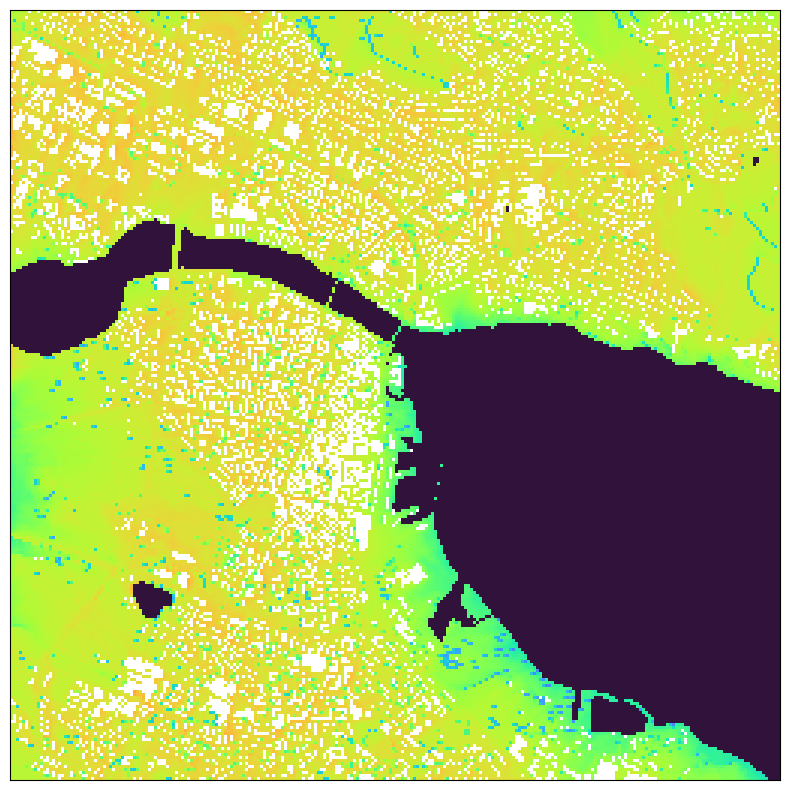

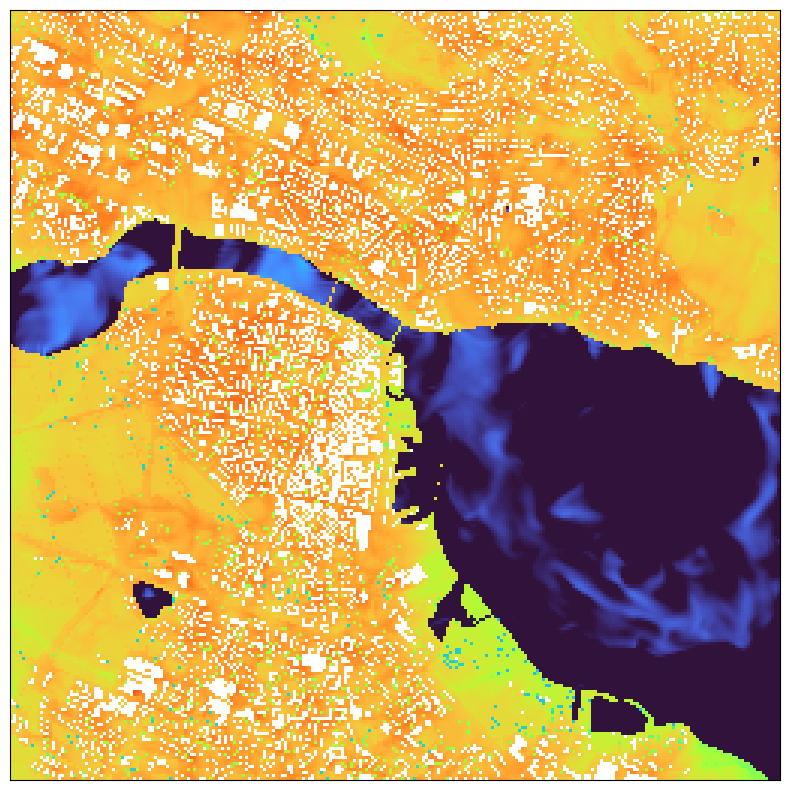

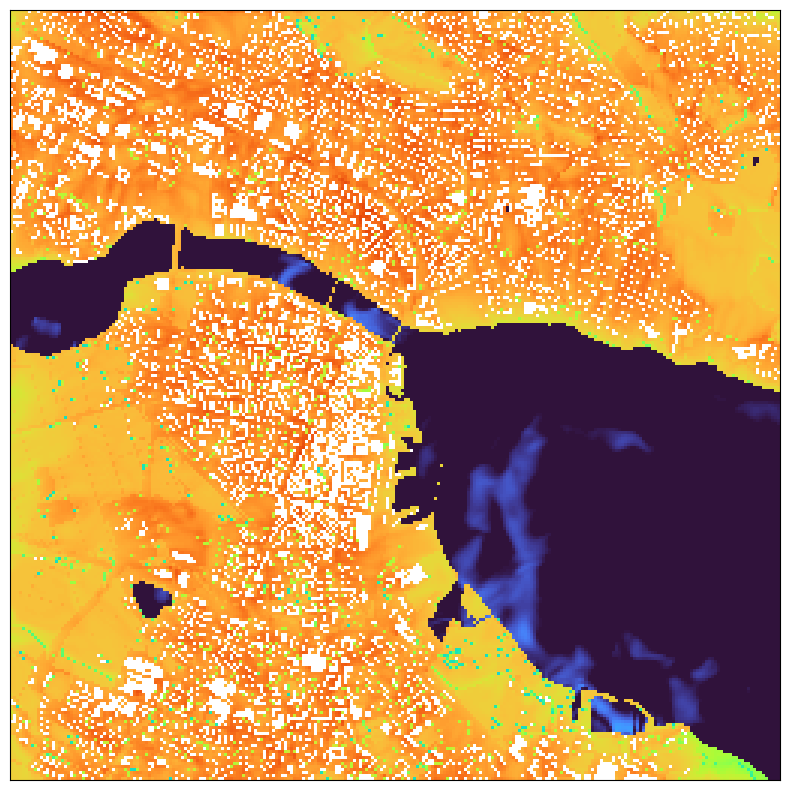

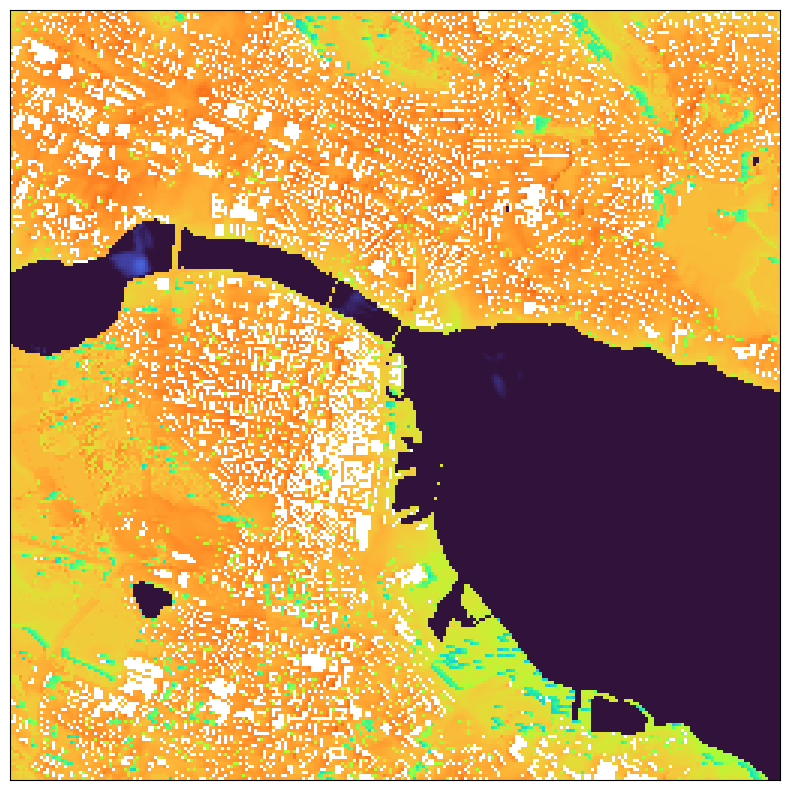

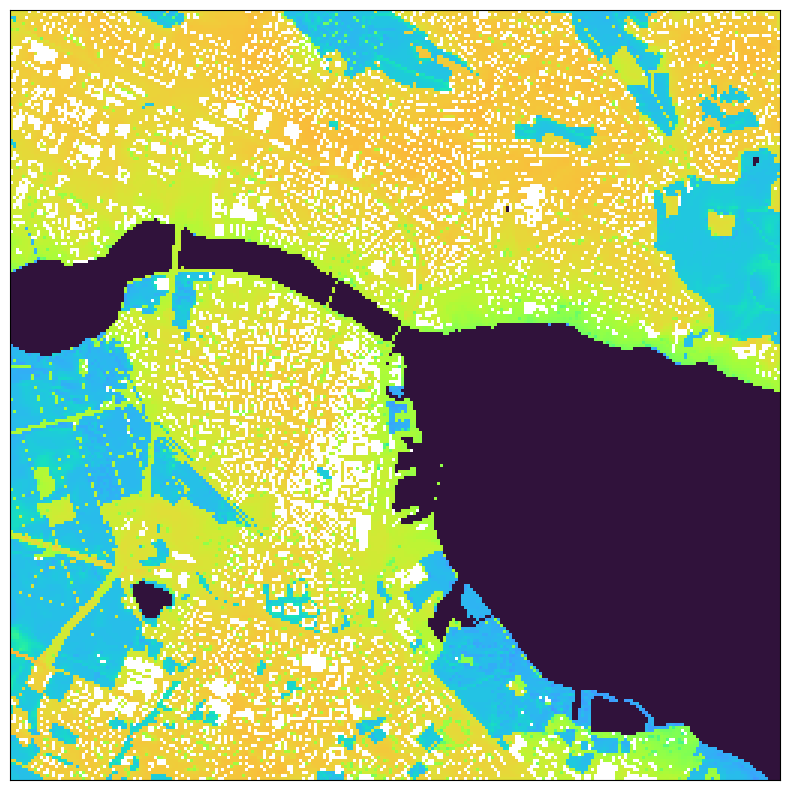

In [44]:
# Function to plot color mesh
def plot_colormesh(band_index):
    # Create single plot
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='w', edgecolor=None)

    # Define plot color and mask
    cmap = plt.get_cmap('turbo')

    # Plot band data and building mask
    toplot = np.ma.masked_array(variable_data_masked[band_index, 0, :, :], mask=bmask_id)
    ax.pcolormesh(x, y, toplot, cmap=cmap, vmin=15, vmax=37.5, alpha=1,)
    ax.set_aspect(1)  # Set the aspect ratio to 1:1 for subplot

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.savefig(f"F:/{simulation}_band_{band_index}.png",transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()

num_colors = 0
bands = (53, 71, 89, 107, 125)
for band_index in bands:
    plot_colormesh(band_index)